<a href="https://colab.research.google.com/github/zeeba-tech/data-science/blob/main/stable_diffusion(strikethrough_experiment).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install --upgrade diffusers transformers scipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 255 kB 25.7 MB/s 
     |████████████████████████████████| 5.3 MB 63.4 MB/s 
     |████████████████████████████████| 163 kB 71.1 MB/s 
     |████████████████████████████████| 7.6 MB 35.1 MB/s 


In [2]:
!pip install -q --upgrade transformers diffusers ftfy

     |████████████████████████████████| 53 kB 1.8 MB/s 


In [3]:
from huggingface_hub import notebook_login
notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token


In [4]:
# set up & imports

import torch
from transformers import CLIPTextModel ,CLIPTokenizer
from transformers import logging
from diffusers import AutoencoderKL , UNet2DConditionModel ,LMSDiscreteScheduler
from tqdm.auto import tqdm
from torch import autocast
from PIL import Image
from matplotlib import pyplot as plt
import numpy
from torchvision import transforms as  tfms

#suppress some unnecessary warnings when loading CLIPTextModel
logging.set_verbosity_error()
#set device
torch_device="cuda" if torch.cuda.is_available() else "cpu"

In [5]:
# loading the models

# loading auto encoder model which will decode latents(text form) into image space
vae=AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

# load the tokenizer and text encoder to tokenize and encode the text
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

#THe UNet Models for generating latents
unet=UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

#The noise scheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

Downloading:   0%|          | 0.00/335M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/522 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/961k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/389 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/905 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/743 [00:00<?, ?B/s]

In [6]:
#To the gpu we go
vae=vae.to(torch_device)
text_encoder=text_encoder.to(torch_device)
unet = unet.to(torch_device);

In [7]:
def gen(prompt,seed=69):
  height = 512                        # default height of Stable Diffusion
  width = 512                         # default width of Stable Diffusion
  num_inference_steps = 30            # Number of denoising steps
  guidance_scale = 7.5                # Scale for classifier-free guidance
  generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise
  batch_size = 1

  # Prep text (first we get text_embeddings for the prompt.these embeddings will be used to condition  the UNet model)
  # Prep text (first we get text_embeddings for the prompt.these embeddings will be used to condition  the UNet model)
  text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
  with torch.no_grad():
      text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
  '''(we will also get unconditional embeddings for classifier free guidance,which are just the embedding for the padded token(empty text).
  they need to have same shape as conditional text_embeddings(batch_size and seq_length))'''     
  max_length = text_input.input_ids.shape[-1]
  uncond_input = tokenizer(
      [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
  )
  with torch.no_grad():
      uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0] 
  #For classifier-free guidance we need two forward passes.one with conditione_input(text_embeddings)and another with unconditioneal embeddings(uncond_embeddings).
  #in general we concatenate both into single batch to avoid doing forward passes
  text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

  # Prep Scheduler(This will compute the sigmas and exact time step values to be used during denoising process)
  scheduler.set_timesteps(num_inference_steps)

  # Prep latents(generate the initial random noise)(latents shape ([1,4,64,64]).the model will transform this latent representation(pure noise) into a 512*512 image later on)
  latents = torch.randn(
    (batch_size, unet.in_channels, height // 8, width // 8),
    generator=generator,
  )
  latents = latents.to(torch_device)#K-LMS scheduler needs to multiply latents by its sigma values.lets do this here
  latents = latents * scheduler.init_noise_sigma # Scaling (previous versions did latents = latents * self.scheduler.sigmas[0]

  # Loop(denoising loop)
  with autocast("cuda"):
      for i, t in tqdm(enumerate(scheduler.timesteps)):
          # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
          latent_model_input = torch.cat([latents] * 2)
          sigma = scheduler.sigmas[i]
          # Scale the latents (preconditioning):
          # latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5) # Diffusers 0.3 and below
          latent_model_input = scheduler.scale_model_input(latent_model_input, t)

          # predict the noise residual
          with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

          # perform guidance
          noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
          noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

          # compute the previous noisy sample x_t -> x_t-1
          # latents = scheduler.step(noise_pred, i, latents)["prev_sample"] # Diffusers 0.3 and below
          latents = scheduler.step(noise_pred, t, latents).prev_sample

  # scale and decode the image latents with vae(now we use the vae to decode generated latents back into image)
  latents = 1 / 0.18215 * latents
  with torch.no_grad():
      image = vae.decode(latents).sample

  # Display(finally lets convert the image to PIL so we can display or save it)
  image = (image / 2 + 0.5).clamp(0, 1)
  image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
  images = (image * 255).round().astype("uint8")
  pil_images = [Image.fromarray(image) for image in images]
  return pil_images[0]

0it [00:00, ?it/s]

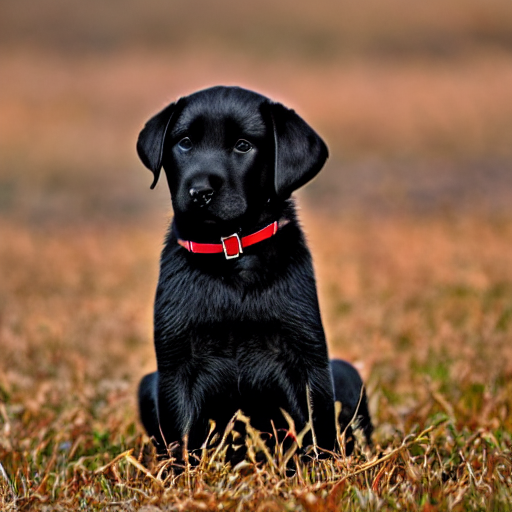

In [10]:
gen(["a photograph of a labrador puppy wearing red collar"],seed=123456789)

0it [00:00, ?it/s]

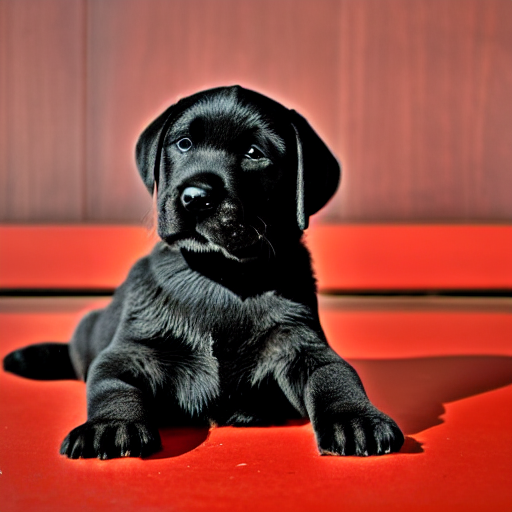

In [11]:
gen(["a photograph of a labrador puppy wearing a ~~red~~ collar"],seed=123456789)